In [3]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

#from google.colab import drive
drive.mount('/content/drive')

from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/MyDrive/Colab Notebooks/뉴스 토픽 분류 경진대회/open2.zip" "open2.zip"
# data.zip을 현재 디렉터리에 압축해제
!unzip "open2.zip"
output.clear()

In [ ]:
# import library 
import numpy as np
from numpy.lib.function_base import _cov_dispatcher
import scipy as sp
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

# 한국어 형태소 및 문장 분석 라이브러리

!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install nltk
from pykospacing import Spacing
import nltk
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
output.clear()

In [37]:
df_train["title"].values[1]

'실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화'

In [118]:
# train & label data load
'''
- train_data: index, title, topic_idx
- topic_dict: topic, topic_idx
- test_data: index, title
'''
PATH = "./"
df_train = pd.read_csv(PATH + "train_data.csv")
df_test = pd.read_csv(PATH + "test_data.csv")
topic_dict = pd.read_csv(PATH + "topic_dict.csv")
kr_stopwords_list = pd.read_csv(PATH + "korean_stopwords.csv", header = None, names = ['word'])["word"].tolist()

# preprocessing
# html tag 및 숫자, 영어, 특수문자 등 제거

# punctuation remove
def clean_punc(text):

    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&' 
    punct_mapping = {
        "‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ",
        "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', 
        '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha',
        '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

    for p in punct_mapping:
        text = text.replace(p, punct_mapping[p])
    
    for p in punct:
        text = text.replace(p, f'{p}')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}

    for s in specials:
        text = text.replace(s, specials[s])

    return text.strip()

# using re to preprocess: remove punct, html tag, number, and lowering, spacing
def clean_text(texts):

    corpus = []
    for i in range(0, len(texts)):

        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','',str(texts[i])) # remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+',' ', review)
        review = re.sub(r'<[^>]+>','',review) #remove Html tags 
        review = re.sub(r'\s+', ' ', review) #remove spaces 
        review = re.sub(r"^\s+", '', review) #remove space from start 
        review = re.sub(r'\s+$', '', review) #remove space from the end corpus.append(review) return corpus

        corpus.append(review)

    return corpus

# dacon sample function
def clean_text_dacon(text):
    text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", text)
    return text_clean

# 맞춤법, 문장 분리, 단어 분리(외부 라이브러리 이용)
    
'''

try:
    from pykospacing import spacing
    from hanspell import spell_checker
    import kss
except:
    pip install git+https://github.com/haven-jeon/PyKoSpacing.git
    pip install kss
    pip install py-hanspell
    from pykospacing import spacing
    from hanspell import spell_checker
    import kss
    
'''


spacing = Spacing()
def text_spacing(text):
    text_spacing = spacing(text)
    return text_spacing

# stemming: 동사를 원형으로 복원
# 불용어 제거, nltk
# 불용어 제거는 먼저 토큰화가 이루어져야 한다. 
    
wnl = WordNetLemmatizer()

def stem_stopwords(text):
    corpus = [wnl.lemmatize(word) for word in text.split(' ') if not word in kr_stopwords_list]
    return corpus

# preprocessing: stopword, spacing, stemming, remove punctuation

def preprocessing(df):

    df_copy = df.copy()
    texts = df_copy["title"].values

    text_inputs = []

    for text in texts:

        text_clean = clean_punc(text)
        text_clean = clean_text_dacon(text_clean)
        # 시간이 오래 걸리는 관계로 spacing함수를 쓰지 않고 split으로 진행
        # text_sc = text_spacing(text_clean)
        text_sc = text_clean
        corpus_stem_stopwords = stem_stopwords(text_sc)
        text_inputs.append(corpus_stem_stopwords)

    return text_inputs

# tokenized

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

text_preprocessed = preprocessing(df_train)
tokenizer = Tokenizer(filters = " ", num_words = 20000)

tokenizer.fit_on_texts(text_preprocessed)
datasets_token = tokenizer.texts_to_sequences(text_preprocessed)
datasets = pad_sequences(datasets_token, padding = "post", dtype = "int32")
print(datasets.shape)

# train - test data split
labels = df_train["topic_idx"].values.reshape(-1,).astype('int32')
x_train, x_test, y_train, y_test = train_test_split(datasets, labels, test_size = 0.3, shuffle = True, random_state = 42)

(45654, 33)


In [114]:
print(type(x_train), x_train[0])
print(type(y_train), y_train[0])

<class 'numpy.ndarray'> [   1    1    1 2526 4164 2160    8    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
<class 'numpy.ndarray'> 1


1

Epoch 1/64
250/250 [==============================] - 4s 11ms/step - loss: 1.9321 - accuracy: 0.1827 - val_loss: 1.8855 - val_accuracy: 0.2203
Epoch 2/64
250/250 [==============================] - 2s 10ms/step - loss: 1.8795 - accuracy: 0.2295 - val_loss: 1.8355 - val_accuracy: 0.2858
Epoch 3/64
250/250 [==============================] - 2s 9ms/step - loss: 1.8170 - accuracy: 0.2886 - val_loss: 1.7353 - val_accuracy: 0.4101
Epoch 4/64
250/250 [==============================] - 2s 10ms/step - loss: 1.6870 - accuracy: 0.3815 - val_loss: 1.5540 - val_accuracy: 0.4722
Epoch 5/64
250/250 [==============================] - 3s 10ms/step - loss: 1.4714 - accuracy: 0.4831 - val_loss: 1.3345 - val_accuracy: 0.5419
Epoch 6/64
250/250 [==============================] - 3s 10ms/step - loss: 1.2481 - accuracy: 0.5605 - val_loss: 1.1110 - val_accuracy: 0.6250
Epoch 7/64
250/250 [==============================] - 2s 10ms/step - loss: 1.0752 - accuracy: 0.6245 - val_loss: 1.0170 - val_accuracy: 0.6443


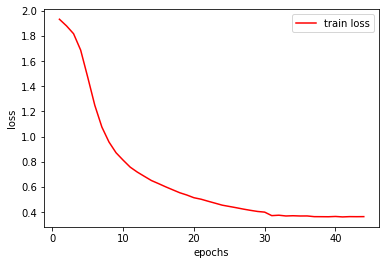

In [132]:
#model parameter

vocab_size = tokenizer.num_words
maxlen = x_train.shape[1]
embed_dim = 32
num_heads = 2
ff_dim = 32

# Transformer block

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = tf.keras.models.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation = "relu"), tf.keras.layers.Dense(embed_dim)]
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training = True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, x):
        maxlen = self.maxlen
        positions = tf.range(start=0, limit = maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    


inputs = tf.keras.layers.Input(shape = (maxlen,), dtype = "int32")
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate = 0.2)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(7, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name = "transformer")
model.compile(
    #optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

# training

batch_size = 128
epochs = 64

es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 12, verbose = 0)
mc = tf.keras.callbacks.ModelCheckpoint("transformer_weights.h5",monitor = "val_loss", mode = "min", patience = 12, save_best_only=True, save_weights_only = True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 4, mode= "min", verbose = 0)

callbacks_params = [es, mc, lr]

tf.debugging.set_log_device_placement(True)
with tf.device("gpu:0"):
    hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), 
                     epochs = epochs, batch_size = batch_size, verbose = 1,
                     callbacks = callbacks_params)
    loss, acc = hist.history["loss"], hist.history["accuracy"]
    epoch_axis = range(1, len(loss) + 1)
    plt.plot(epoch_axis, loss, "r", label = "train loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show() 

In [154]:
from google.colab import files

# test file -> convert word embedding vector

submission_test = preprocessing(df_test)
submission_test = tokenizer.texts_to_sequences(submission_test)
submission_test = pad_sequences(submission_test, padding = "post", dtype = "int32", maxlen = maxlen)

def softmax_toIdx(predictions):
    topic_Idx = np.argmax(predictions, axis = 1).reshape(-1,1)
    return topic_Idx

# prediction
submission_topic = softmax_toIdx(model.predict(submission_test))

# submission 
submission = pd.read_csv(PATH + "sample_submission.csv")
submission["topic_idx"] = submission_topic
submission.to_csv("submission.csv", index = False)
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>